In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
from pyspark.sql.functions import col, avg, count, round, corr, trim, length

# Initialize Spark session
spark = SparkSession.builder.appName("Food Delivery App Analysis").getOrCreate()



In [0]:
review_schema = StructType([
    StructField("content", StringType(), True),  # Full text of the user review
    StructField("score", IntegerType(), True),  # Star rating (1-5)
    StructField("thumbsUpCount", IntegerType(), True),  # Number of likes on the review
    StructField("Apps", StringType(), True),  # App name (DoorDash, Grubhub, Uber Eats)
    StructField("sentiment", StringType(), True),  # Sentiment category (Positive, Neutral, Negative)
    StructField("afinn_score", DoubleType(), True),  # AFINN sentiment score
    StructField("vader_neg", DoubleType(), True),  # VADER negative sentiment score
    StructField("vader_neu", DoubleType(), True),  # VADER neutral sentiment score
    StructField("vader_pos", DoubleType(), True),  # VADER positive sentiment score
    StructField("vader_compound", DoubleType(), True),  # VADER overall sentiment score
    StructField("word_count", IntegerType(), True),  # Number of words in the review
    StructField("Ease_of_Use", IntegerType(), True),  # Ease of use (-1, 0, 1)
    StructField("Intention_to_Use", IntegerType(), True),  # Intention to use (-1, 0, 1)
    StructField("Usefulness", IntegerType(), True)  # Usefulness (-1, 0, 1)
])

df = spark.read.schema(review_schema).format("csv").option("header","true").option("wholeFile", "true").load("s3://ipl-spark/Final data.csv") #option("inferSchema","true")

# Display the schema
df.show(5)

+--------------------+-----+-------------+--------+---------+-----------+---------+---------+---------+--------------+----------+-----------+----------------+----------+
|             content|score|thumbsUpCount|    Apps|sentiment|afinn_score|vader_neg|vader_neu|vader_pos|vader_compound|word_count|Ease_of_Use|Intention_to_Use|Usefulness|
+--------------------+-----+-------------+--------+---------+-----------+---------+---------+---------+--------------+----------+-----------+----------------+----------+
|deleted dont like...|    1|            0|DoorDash|       -1|       -1.0|    0.102|    0.814|    0.084|        0.1002|        31|         -1|              -1|        -1|
|while abbreviatio...|    5|            0|DoorDash|        1|        7.0|      0.0|    0.561|    0.439|          0.91|        20|          0|               0|         0|
|They come through...|    5|            0|DoorDash|        1|       -1.0|      0.0|    0.841|    0.159|        0.2235|        11|          0|         

In [0]:
# Drop any null values
df = df.na.drop()

# Convert categorical columns to lowercase for uniformity
df = df.withColumn("Apps", col("Apps").cast("string"))
df = df.withColumn("content", col("content").cast("string"))

# Convert numerical columns to appropriate types
numeric_cols = ["score", "thumbsUpCount", "afinn_score", "vader_neg", "vader_neu",
                "vader_pos", "vader_compound", "word_count", "Ease_of_Use",
                "Intention_to_Use", "Usefulness"]

for col_name in numeric_cols:
    df = df.withColumn(col_name, col(col_name).cast("double"))

df.show(5)


+--------------------+-----+-------------+--------+---------+-----------+---------+---------+---------+--------------+----------+-----------+----------------+----------+
|             content|score|thumbsUpCount|    Apps|sentiment|afinn_score|vader_neg|vader_neu|vader_pos|vader_compound|word_count|Ease_of_Use|Intention_to_Use|Usefulness|
+--------------------+-----+-------------+--------+---------+-----------+---------+---------+---------+--------------+----------+-----------+----------------+----------+
|deleted dont like...|  1.0|          0.0|DoorDash|       -1|       -1.0|    0.102|    0.814|    0.084|        0.1002|      31.0|       -1.0|            -1.0|      -1.0|
|while abbreviatio...|  5.0|          0.0|DoorDash|        1|        7.0|      0.0|    0.561|    0.439|          0.91|      20.0|        0.0|             0.0|       0.0|
|They come through...|  5.0|          0.0|DoorDash|        1|       -1.0|      0.0|    0.841|    0.159|        0.2235|      11.0|        0.0|         

In [0]:
# Trim white spaces from categorical columns
df = df.withColumn("Apps", trim(col("Apps")))
df = df.withColumn("sentiment", trim(col("sentiment")))

# Remove null or empty values
df = df.filter(col("Apps").isNotNull() & (col("Apps") != ""))
df = df.filter(col("sentiment").isNotNull() & (col("sentiment") != ""))

# Show cleaned data
df.show(5)


+--------------------+-----+-------------+--------+---------+-----------+---------+---------+---------+--------------+----------+-----------+----------------+----------+
|             content|score|thumbsUpCount|    Apps|sentiment|afinn_score|vader_neg|vader_neu|vader_pos|vader_compound|word_count|Ease_of_Use|Intention_to_Use|Usefulness|
+--------------------+-----+-------------+--------+---------+-----------+---------+---------+---------+--------------+----------+-----------+----------------+----------+
|deleted dont like...|  1.0|          0.0|DoorDash|       -1|       -1.0|    0.102|    0.814|    0.084|        0.1002|      31.0|       -1.0|            -1.0|      -1.0|
|while abbreviatio...|  5.0|          0.0|DoorDash|        1|        7.0|      0.0|    0.561|    0.439|          0.91|      20.0|        0.0|             0.0|       0.0|
|They come through...|  5.0|          0.0|DoorDash|        1|       -1.0|      0.0|    0.841|    0.159|        0.2235|      11.0|        0.0|         

In [0]:
df.describe().show()


+-------+------------------+------------------+------------------+---------+-------------------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+--------------------+--------------------+-------------------+
|summary|           content|             score|     thumbsUpCount|     Apps|          sentiment|       afinn_score|           vader_neg|          vader_neu|          vader_pos|     vader_compound|        word_count|         Ease_of_Use|    Intention_to_Use|         Usefulness|
+-------+------------------+------------------+------------------+---------+-------------------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+--------------------+--------------------+-------------------+
|  count|           1682618|           1682618|           1682618|  1682618|            1682618|           1682618|             1682618|            1682618|          

In [0]:
df = df.drop("content")
df.show(5)

+-----+-------------+--------+---------+-----------+---------+---------+---------+--------------+----------+-----------+----------------+----------+
|score|thumbsUpCount|    Apps|sentiment|afinn_score|vader_neg|vader_neu|vader_pos|vader_compound|word_count|Ease_of_Use|Intention_to_Use|Usefulness|
+-----+-------------+--------+---------+-----------+---------+---------+---------+--------------+----------+-----------+----------------+----------+
|  1.0|          0.0|DoorDash|       -1|       -1.0|    0.102|    0.814|    0.084|        0.1002|      31.0|       -1.0|            -1.0|      -1.0|
|  5.0|          0.0|DoorDash|        1|        7.0|      0.0|    0.561|    0.439|          0.91|      20.0|        0.0|             0.0|       0.0|
|  5.0|          0.0|DoorDash|        1|       -1.0|      0.0|    0.841|    0.159|        0.2235|      11.0|        0.0|             0.0|       0.0|
|  5.0|          0.0|DoorDash|        1|        3.0|      0.0|    0.323|    0.677|        0.6369|       3.

In [0]:
df.groupBy("Apps").count().orderBy(col("count").desc()).show()


+---------+------+
|     Apps| count|
+---------+------+
|Uber_Eats|859843|
| DoorDash|633041|
|  Grubhub|189734|
+---------+------+



In [0]:
# Average Sentiment Scores Per App
df.groupBy("Apps").agg(
    round(avg("score"), 2).alias("Avg_Star_Rating"),
    round(avg("afinn_score"), 2).alias("Avg_AFINN_Score"),
    round(avg("vader_compound"), 2).alias("Avg_VADER_Compound_Score")
).orderBy(col("Avg_Star_Rating").desc()).show()


+---------+---------------+---------------+------------------------+
|     Apps|Avg_Star_Rating|Avg_AFINN_Score|Avg_VADER_Compound_Score|
+---------+---------------+---------------+------------------------+
| DoorDash|           4.01|           1.74|                    0.33|
|  Grubhub|            3.7|           1.47|                    0.27|
|Uber_Eats|           3.55|           1.16|                    0.21|
+---------+---------------+---------------+------------------------+



In [0]:
# Sentiment Breakdown Per App
df.groupBy("Apps", "sentiment").count().orderBy("Apps").show()


+---------+---------+------+
|     Apps|sentiment| count|
+---------+---------+------+
| DoorDash|       -1|125853|
| DoorDash|        1|477375|
| DoorDash|        0| 29813|
|  Grubhub|        1|125807|
|  Grubhub|       -1| 51999|
|  Grubhub|        0| 11928|
|Uber_Eats|        0| 36431|
|Uber_Eats|        1|543084|
|Uber_Eats|       -1|280328|
+---------+---------+------+



In [0]:


total_reviews = df.groupBy("Apps").count().withColumnRenamed("count", "total_count")

# Count negative reviews per app
negative_reviews = df.filter(col("sentiment") == "-1").groupBy("Apps").count().withColumnRenamed("count", "negative_count")

# Join the two DataFrames
negative_percent = negative_reviews.join(total_reviews, "Apps", "inner")\
    .withColumn("Neg_Review_Percentage", round((col("negative_count") / col("total_count")) * 100, 2))\
    .select("Apps", "Neg_Review_Percentage")

# Show result
negative_percent.show()

+---------+---------------------+
|     Apps|Neg_Review_Percentage|
+---------+---------------------+
| DoorDash|                19.88|
|  Grubhub|                27.41|
|Uber_Eats|                 32.6|
+---------+---------------------+



In [0]:
df.groupBy("sentiment").agg(
    round(avg("Ease_of_Use"), 2).alias("Avg_Ease_of_Use"),
    round(avg("Intention_to_Use"), 2).alias("Avg_Intention_to_Use"),
    round(avg("Usefulness"), 2).alias("Avg_Usefulness")
).orderBy("sentiment").show()


+---------+---------------+--------------------+--------------+
|sentiment|Avg_Ease_of_Use|Avg_Intention_to_Use|Avg_Usefulness|
+---------+---------------+--------------------+--------------+
|       -1|           -1.0|                -1.0|          -1.0|
|        0|           0.06|                 0.0|          0.05|
|        1|           0.09|                 0.0|          0.06|
+---------+---------------+--------------------+--------------+



In [0]:
# Does Review Length Impact Sentiment?
df.select(corr("word_count", "vader_compound")).show()
df.select(corr("word_count", "afinn_score")).show()

+--------------------------------+
|corr(word_count, vader_compound)|
+--------------------------------+
|             -0.3316433906132246|
+--------------------------------+

+-----------------------------+
|corr(word_count, afinn_score)|
+-----------------------------+
|            -0.27396909822482|
+-----------------------------+



In [0]:
df.select(corr("thumbsUpCount", "vader_compound")).show()


+-----------------------------------+
|corr(thumbsUpCount, vader_compound)|
+-----------------------------------+
|               -0.03284213463451387|
+-----------------------------------+



In [0]:
# Apps With Highest Ratings

df.groupBy("Apps").agg(avg("score").alias("Avg_Score")).orderBy(col("Avg_Score").desc()).show()


+---------+------------------+
|     Apps|         Avg_Score|
+---------+------------------+
| DoorDash|4.0086076573239335|
|  Grubhub| 3.697407950077477|
|Uber_Eats|3.5495863779783052|
+---------+------------------+



In [0]:
# Apps With Most Negative Reviews
df.filter(col("sentiment") == "-1").groupBy("Apps").count().orderBy(col("count").desc()).show()


+---------+------+
|     Apps| count|
+---------+------+
|Uber_Eats|280328|
| DoorDash|125853|
|  Grubhub| 51999|
+---------+------+



In [0]:
# Apps With Most Negative Reviews
df.filter(col("sentiment") == "1").groupBy("Apps").count().orderBy(col("count").desc()).show()


+---------+------+
|     Apps| count|
+---------+------+
|Uber_Eats|543084|
| DoorDash|477375|
|  Grubhub|125807|
+---------+------+



In [0]:
def spark_to_pandas(spark_df):
    return spark_df.toPandas()

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set_style("whitegrid")

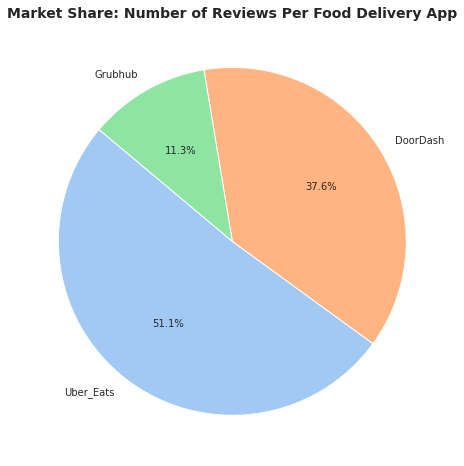

In [0]:
reviews_per_app = df.groupBy("Apps").count().orderBy(col("count").desc())
reviews_per_app_pd = spark_to_pandas(reviews_per_app)

plt.figure(figsize=(8, 8))
colors = sns.color_palette("pastel")
plt.pie(reviews_per_app_pd["count"], labels=reviews_per_app_pd["Apps"], autopct='%1.1f%%', colors=colors, startangle=140)
plt.title("Market Share: Number of Reviews Per Food Delivery App", fontsize=14, fontweight='bold')
plt.show()

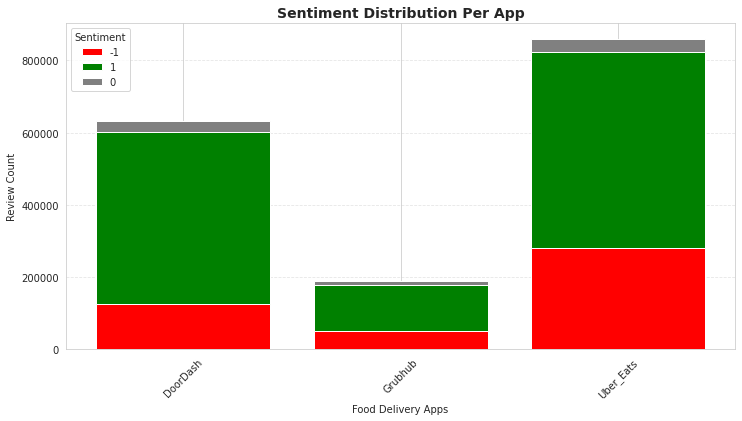

In [0]:
sentiment_distribution = df.groupBy("Apps", "sentiment").count()
sentiment_distribution_pd = spark_to_pandas(sentiment_distribution)

plt.figure(figsize=(12, 6))
apps = sentiment_distribution_pd["Apps"].unique()
sentiments = sentiment_distribution_pd["sentiment"].unique()
colors = ["red", "green", "grey"]  # Negative, Positive, Neutral

bottom_vals = np.zeros(len(apps))
for idx, sentiment in enumerate(sentiments):
    subset = sentiment_distribution_pd[sentiment_distribution_pd["sentiment"] == sentiment]
    plt.bar(subset["Apps"], subset["count"], bottom=bottom_vals, label=sentiment, color=colors[idx])
    bottom_vals += subset["count"].values

plt.xlabel("Food Delivery Apps")
plt.ylabel("Review Count")
plt.title("Sentiment Distribution Per App", fontsize=14, fontweight='bold')
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.show()

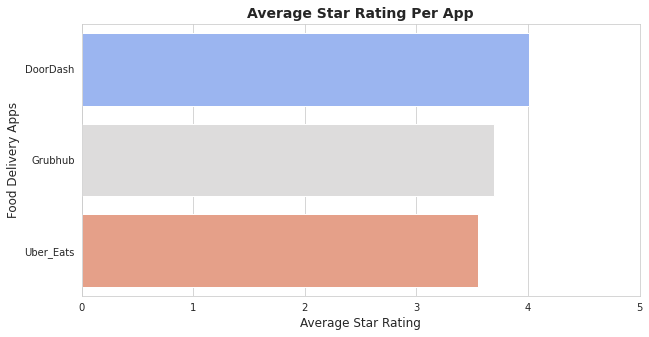

In [0]:
avg_star_rating = df.groupBy("Apps").agg(avg("score").alias("Avg_Star_Rating"))
avg_star_rating_pd = spark_to_pandas(avg_star_rating)

plt.figure(figsize=(10, 5))
sns.barplot(y=avg_star_rating_pd["Apps"], x=avg_star_rating_pd["Avg_Star_Rating"], palette="coolwarm")
plt.xlabel("Average Star Rating", fontsize=12)
plt.ylabel("Food Delivery Apps", fontsize=12)
plt.title("Average Star Rating Per App", fontsize=14, fontweight='bold')
plt.xlim(0, 5)
plt.show()

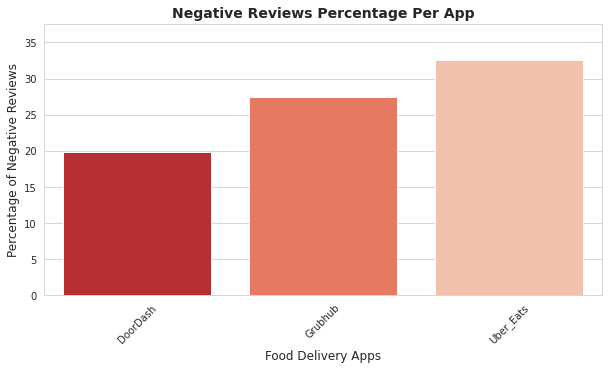

In [0]:
total_reviews = df.groupBy("Apps").count().withColumnRenamed("count", "total_count")
negative_reviews = df.filter(col("sentiment") == "-1").groupBy("Apps").count().withColumnRenamed("count", "negative_count")

negative_percent = negative_reviews.join(total_reviews, "Apps", "inner").withColumn("Neg_Review_Percentage", round((col("negative_count") / col("total_count")) * 100, 2))

negative_percent_pd = spark_to_pandas(negative_percent)

plt.figure(figsize=(10, 5))
sns.barplot(x=negative_percent_pd["Apps"], y=negative_percent_pd["Neg_Review_Percentage"], palette="Reds_r")
plt.xlabel("Food Delivery Apps", fontsize=12)
plt.ylabel("Percentage of Negative Reviews", fontsize=12)
plt.title("Negative Reviews Percentage Per App", fontsize=14, fontweight='bold')
plt.ylim(0, max(negative_percent_pd["Neg_Review_Percentage"]) + 5)
plt.xticks(rotation=45)
plt.show()

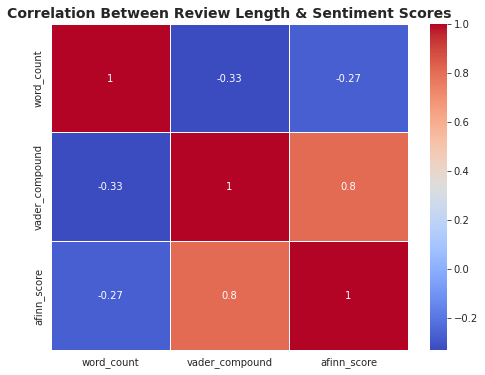

In [0]:
correlation_data = df.select("word_count", "vader_compound", "afinn_score").toPandas().corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_data, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Review Length & Sentiment Scores", fontsize=14, fontweight='bold')
plt.show()

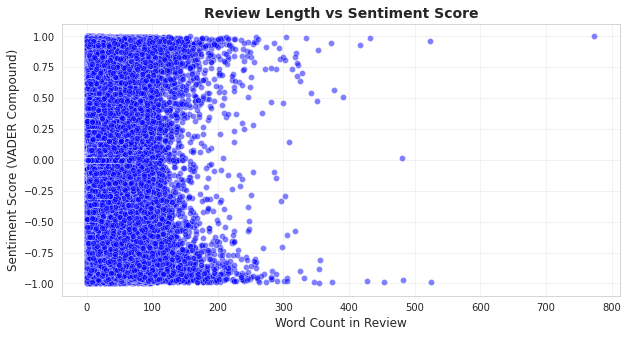

In [0]:
word_sentiment_pd = df.select("word_count", "vader_compound").toPandas()

plt.figure(figsize=(10, 5))
sns.scatterplot(x=word_sentiment_pd["word_count"], y=word_sentiment_pd["vader_compound"], alpha=0.5, color="blue")
plt.xlabel("Word Count in Review", fontsize=12)
plt.ylabel("Sentiment Score (VADER Compound)", fontsize=12)
plt.title("Review Length vs Sentiment Score", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.show()